# Denoising Model Training

## Basic information in this notebook

In [1]:
%load_ext autoreload
%autoreload 2

!python --version

Python 3.13.11


In [2]:
import torch

if torch.cuda.is_available():
    # Get the number of available GPUs
    gpu_count = torch.cuda.device_count()
    print(f"CUDA is available. Number of GPUs: {gpu_count}")
    
    # Iterate over all available GPUs to print details
    for i in range(gpu_count):
        print(f"\n--- GPU Device {i} ---")
        # Get the name of the GPU
        print(f"Device Name: {torch.cuda.get_device_name(i)}")
        
        # Get general properties
        properties = torch.cuda.get_device_properties(i)
        print(f"Total Memory: {round(properties.total_memory / (1024**3), 2)} GB")
        print(f"Multiprocessor Count: {properties.multi_processor_count}")
        print(f"CUDA Capability: {properties.major}.{properties.minor}")

else:
    print("CUDA is not available. PyTorch is using CPU.")

# for MAC GPU
print("\nChecking for MPS (Apple Silicon GPU) support...")
if torch.backends.mps.is_available():
    print("MPS (GPU) is available.")
else:
    print("MPS not available.")

CUDA is available. Number of GPUs: 1

--- GPU Device 0 ---
Device Name: NVIDIA GeForce RTX 4090
Total Memory: 23.52 GB
Multiprocessor Count: 128
CUDA Capability: 8.9

Checking for MPS (Apple Silicon GPU) support...
MPS not available.


## Data Load and presentation

In [3]:
import gc
gc.collect()

import torch
torch.cuda.empty_cache()

In [ ]:
""" Default or Suggested Settings """
PATCH_SIZE_2D = (64, 64)
PATCH_SIZE_3D = (32, 64, 64)
SLIDE_WINDOW_2D = (16, 16)
SLIDE_WINDOW_3D = (8, 16, 16)
NMODE_ENABLE = False
SEED = 42
MASK_MODE = "gaussian"  # "gaussian", "global_surrounding", "local_surrounding"

""" overwrite settings below """

""" Set PATCH_SIZE to either 2D or 3D based on your requirements"""
# PATCH_SIZE = PATCH_SIZE_2D
PATCH_SIZE = PATCH_SIZE_3D

# SLIDE_WINDOW = SLIDE_WINDOW_2D
SLIDE_WINDOW = SLIDE_WINDOW_3D

# MASK_MODE = "local_surrounding"

NMODE_ENABLE = True

In [5]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    """
    DataLoader 的 worker 初始化函數
    確保每個 worker 擁有獨立但固定的 NumPy/Python seed
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
seed_everything(SEED)
# 建立 Generator
g = torch.Generator()
g.manual_seed(SEED) # 這裡要跟 seed_everything 一樣

In [6]:
import pathlib
import sys, os
import tifffile
from torch.utils.data import DataLoader
from dataset import CalciumDataset

if "google.colab" in sys.modules:
    train_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/train")
    valid_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/valid")
    ground_truth_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/valid/F0.tif")
else:
    train_path = pathlib.Path("data/train")
    valid_path = pathlib.Path("data/valid")
    ground_truth_path = pathlib.Path("data/valid/F0.tif")

train_paths = list(train_path.glob("*.tif"))
valid_paths = [p for p in valid_path.glob("*.tif") if "f0" not in p.name.lower()]
ground_truth = tifffile.imread(ground_truth_path)

print(len(train_paths), len(valid_paths))

if PATCH_SIZE == PATCH_SIZE_2D:
    train_dataset = CalciumDataset(train_paths, subset="train", patch_size=PATCH_SIZE, samples_per_epoch=8000, mask_mode=MASK_MODE)
    valid_dataset = CalciumDataset(valid_paths, subset="valid", patch_size=PATCH_SIZE, samples_per_epoch=2000, mask_mode=MASK_MODE)
elif PATCH_SIZE == PATCH_SIZE_3D:
    train_dataset = CalciumDataset(train_paths, subset="train", patch_size=PATCH_SIZE, samples_per_epoch=8000, mask_mode=MASK_MODE)
    valid_dataset = CalciumDataset(valid_paths, subset="valid", patch_size=PATCH_SIZE, samples_per_epoch=2000, mask_mode=MASK_MODE)
else:
    raise ValueError("Invalid PATCH_SIZE. Must be either PATCH_SIZE_2D or PATCH_SIZE_3D.")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, worker_init_fn=seed_worker, generator=g)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2, worker_init_fn=seed_worker, generator=g)

4 3


In [7]:
valid_paths.sort()
valid_paths

[PosixPath('data/valid/F1.tif'),
 PosixPath('data/valid/F2.tif'),
 PosixPath('data/valid/F3.tif')]

In [8]:
for normals in train_dataset.normals:
    print(normals)
for normals in valid_dataset.normals:
    print(normals)

(np.float64(-89.0), np.float64(1275.0))
(np.float64(-89.0), np.float64(1275.0))
(np.float64(-89.0), np.float64(1275.0))
(np.float64(-89.0), np.float64(1275.0))
(np.float64(-100.0), np.float64(2090.0))
(np.float64(-100.0), np.float64(2090.0))
(np.float64(-100.0), np.float64(2090.0))


## Model architecture


In [9]:
from model_arch.unet import UNet, UNet3D, UNetnmODE

## Model training

In [10]:
from training import train

best_model = None
if PATCH_SIZE == PATCH_SIZE_3D:
    if NMODE_ENABLE:
        model = UNetnmODE()
        print("Using UNet with nmODE")
    else:
        model = UNet3D()
        print("Using 3D UNet")
elif PATCH_SIZE == PATCH_SIZE_2D:
    model = UNet()
    print("Using 2D UNet")
    
best_model = train(model, train_loader, valid_loader, epochs=5)

Using UNet with nmODE


Epoch 1/5


100%|██████████| 250/250 [01:19<00:00,  3.14it/s, loss=0.0157]
/workspace/grand-challenge-ai4life-cidc-2025/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3824: RuntimeWarning: Mean of empty slice
  return _methods._mean(a, axis=axis, dtype=dtype,
/workspace/grand-challenge-ai4life-cidc-2025/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 63/63 [00:06<00:00,  9.24it/s, loss=0.0157]


Epoch: 1, Valid Loss: 0.01833641490647717
Best model saved with loss: 0.01833641490647717
Epoch 2/5


100%|██████████| 63/63 [00:06<00:00,  9.23it/s, loss=0.0157]


Epoch: 2, Valid Loss: 0.018253020099585966
Best model saved with loss: 0.018253020099585966
Epoch 3/5


100%|██████████| 63/63 [00:06<00:00,  9.05it/s, loss=0.0156]


Epoch: 3, Valid Loss: 0.018141938343880667
Best model saved with loss: 0.018141938343880667
Epoch 4/5


100%|██████████| 63/63 [00:06<00:00,  9.24it/s, loss=0.0156]


Epoch: 4, Valid Loss: 0.018152674453126058
Epoch 5/5


100%|██████████| 63/63 [00:06<00:00,  9.33it/s, loss=0.0155]


Epoch: 5, Valid Loss: 0.01810742159270578
Best model saved with loss: 0.01810742159270578
Training complete.


# Full Images Evaluation

In [11]:
import numpy as np

def calc_snr(clean, noisy, eps=1e-8):
    signal = np.mean(clean ** 2)
    noise = np.mean((clean - noisy) ** 2)
    if signal == 0:
        return 0.0
    return 10 * np.log10(signal / (noise + eps))

def calc_metrics(clean_video, denoised_video, alpha=0.5, eps=1e-8):

    T, H, W = clean_video.shape

    # --- 1. 初始化容器 ---
    # sSNR: 我們只需要存每一幀算出的一個純量數值 (Scalar)
    s_snr_list = []

    # tSNR: 我們需要兩個 (H, W) 的累加器，用來存總和
    # 使用 float64 以避免累加過程溢位
    acc_pixel_signal_sq = np.zeros((H, W), dtype=np.float64)
    acc_pixel_noise_sq = np.zeros((H, W), dtype=np.float64)

    # --- 2. 逐幀迴圈 (Streaming Loop) ---
    for t in range(T):
        # 取出一幀 (這樣只佔用一張圖的 RAM)
        # 轉成 float64 確保運算精度
        frame_clean = clean_video[t].astype(np.float64)
        frame_restored = denoised_video[t].astype(np.float64)

        # 算出這一幀的誤差
        frame_noise = frame_clean - frame_restored

        # --- A. 處理 sSNR (Spatial) ---
        # 針對這單一幀算 SNR
        f_sig_pow = np.mean(frame_clean ** 2)
        f_ns_pow = np.mean(frame_noise ** 2)

        if f_sig_pow > eps:
            s_snr_val = 10 * np.log10(f_sig_pow / (f_ns_pow + eps))
        else:
            s_snr_val = 0.0 # 若該幀全黑

        s_snr_list.append(s_snr_val)

        # --- B. 處理 tSNR (Temporal) ---
        # 把這一幀的平方值「累加」到蓄水池裡
        acc_pixel_signal_sq += (frame_clean ** 2)
        acc_pixel_noise_sq += (frame_noise ** 2)

    # --- 3. 迴圈結束，計算最終結果 ---

    # A. sSNR 結果: 直接平均列表
    s_snr = np.mean(s_snr_list)

    # B. tSNR 結果:
    # 先算出平均功率 (除以時間 T)
    pixel_signal_power = acc_pixel_signal_sq / T
    pixel_noise_power = acc_pixel_noise_sq / T

    # 逐像素計算 dB
    valid_pixels = pixel_signal_power > eps
    pixel_snr_vals = np.zeros_like(pixel_signal_power)

    pixel_snr_vals[valid_pixels] = 10 * np.log10(
        pixel_signal_power[valid_pixels] / (pixel_noise_power[valid_pixels] + eps)
    )

    t_snr = np.mean(pixel_snr_vals)

    # C. stSNR 結果
    st_snr = alpha * s_snr + (1 - alpha) * t_snr

    return s_snr, t_snr, st_snr

## Denoising validation dataset

In [12]:
import torch
import numpy as np

from inference import denoise_video

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if PATCH_SIZE == PATCH_SIZE_2D:
    model_eval = UNet(in_channels=1, out_channels=1)
elif PATCH_SIZE == PATCH_SIZE_3D:
    if NMODE_ENABLE:
        model_eval = UNetnmODE(in_channels=1, out_channels=1)
    else:
        model_eval = UNet3D(in_channels=1, out_channels=1)
else:
    raise ValueError

# Load the best weights
# if best_model is None:
#     # model_eval = torch.load("models/best_full_model.pth")
#     best_model_weights = torch.load("models/best_model_state_dict.pth")
#     model_eval.load_state_dict(best_model_weights)

best_model_weights = torch.load("models/best_model_state_dict.pth")
model_eval.load_state_dict(best_model_weights)


# lower, upper = valid_dataset.normals[0]

denoised_videos = []

for i, video in enumerate(valid_dataset.images):
    print(video.shape)

    lower, upper = valid_dataset.normals[i]
    video = np.clip(video, lower, upper)
    video = (video - lower) / (upper - lower + 1e-8)

    denoised_video = denoise_video(model_eval, video, patch_size=PATCH_SIZE, slide_window=SLIDE_WINDOW, batch_size=64, skip_frame=False)

    # restore normalization
    denoised_video = denoised_video.squeeze(0).squeeze(0).cpu().numpy()
    denoised_video = denoised_video * (upper - lower + 1e-8) + lower

    # metrics
    s_snr, t_snr, st_snr = calc_metrics(clean_video=ground_truth, denoised_video=denoised_video)
    print(f"F{i+1}: sSNR = {s_snr:.4f}, tSNR = {t_snr:.4f}, stSNR = {st_snr:.4f}")

    denoised_videos.append(denoised_video)

denoised_videos[0][0]

(1500, 490, 490)


100%|██████████| 47/47 [05:10<00:00,  6.60s/it]


F 1: sSNR = 18.2777, tSNR = 20.5703, stSNR = 19.4240
(1500, 490, 490)


100%|██████████| 47/47 [05:10<00:00,  6.60s/it]


F 2: sSNR = 15.9824, tSNR = 17.0633, stSNR = 16.5228
(1500, 490, 490)


100%|██████████| 47/47 [05:10<00:00,  6.60s/it]


F 3: sSNR = 12.5747, tSNR = 12.3876, stSNR = 12.4812


array([[299.5230034 , 292.90802106, 248.2419686 , ..., 127.08396822,
        123.01595233, 118.24076757],
       [333.03876162, 311.64891005, 249.09119129, ..., 134.25336182,
        123.47074971, 123.07588384],
       [357.2681883 , 330.93608454, 266.46391899, ..., 150.73697232,
        142.50475317, 135.83990678],
       ...,
       [158.4439709 , 168.77803497, 187.18823195, ..., 332.81590715,
        338.69816855, 341.61593363],
       [161.21566825, 166.4403148 , 197.96820074, ..., 346.96669251,
        362.41103888, 362.01620564],
       [156.99381784, 169.86840323, 195.34991369, ..., 337.90233433,
        359.70000729, 366.84969023]], shape=(490, 490))

## Evaluate SNR

In [13]:
metrics = []
for i in range(len(denoised_videos)):
    metrics.append(calc_metrics(ground_truth, denoised_videos[i]))
metrics, np.mean(metrics, axis=0)

([(np.float64(18.277658834504788),
   np.float64(20.570307394212787),
   np.float64(19.423983114358787)),
  (np.float64(15.98235957553728),
   np.float64(17.06328963937856),
   np.float64(16.52282460745792)),
  (np.float64(12.57471358002151),
   np.float64(12.387614064213608),
   np.float64(12.481163822117558))],
 array([15.61157733, 16.67373703, 16.14265718]))

## Show denoising images

--- Inspecting frame index: 1499 ---
[F0 (GT)] Min: 1.0000, Max: 2393.0000, Mean: 211.3260, Median: 201.0000
[F1 (Noisy)] Min: -171.0000, Max: 2578.0000, Mean: 211.4232, Median: 196.0000
[Denoised] Min: 1.6477, Max: 2248.9431, Mean: 216.4369, Median: 203.3080


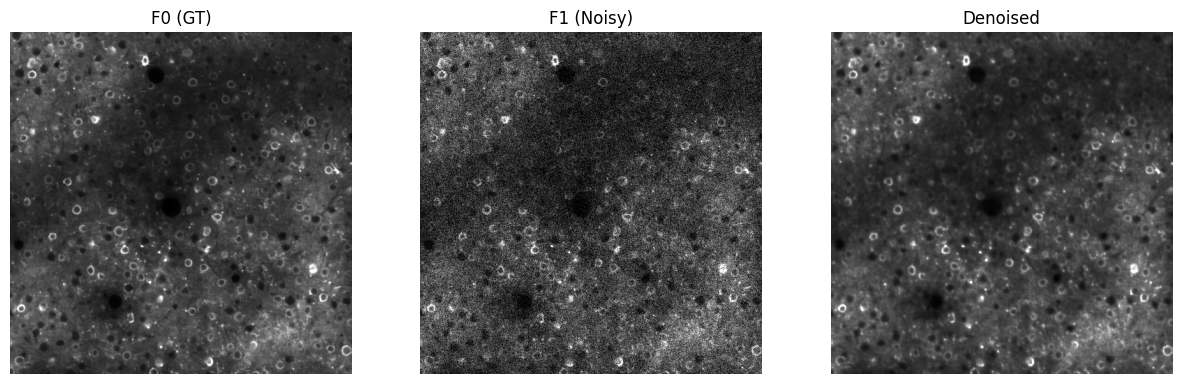

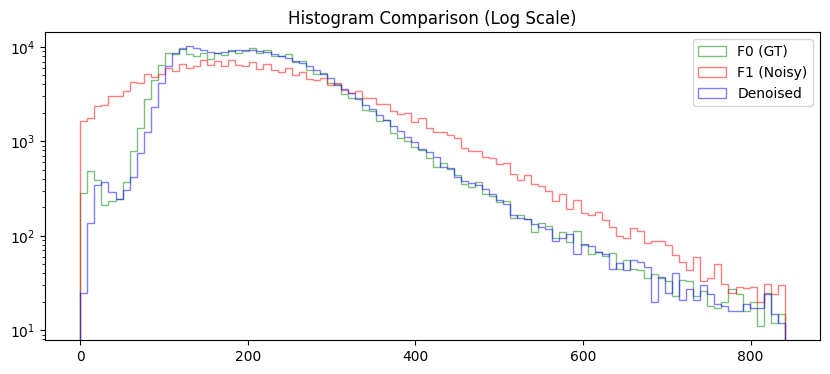

--- Inspecting frame index: 1499 ---
[F0 (GT)] Min: 1.0000, Max: 2393.0000, Mean: 211.3260, Median: 201.0000
[F1 (Noisy)] Min: -208.0000, Max: 2826.0000, Mean: 211.0904, Median: 192.0000
[Denoised] Min: 10.4479, Max: 2065.0916, Mean: 214.2445, Median: 202.2052


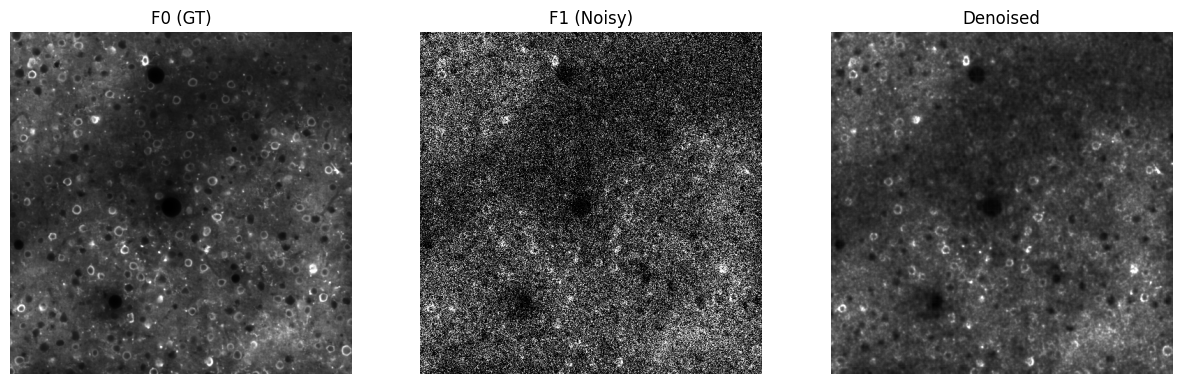

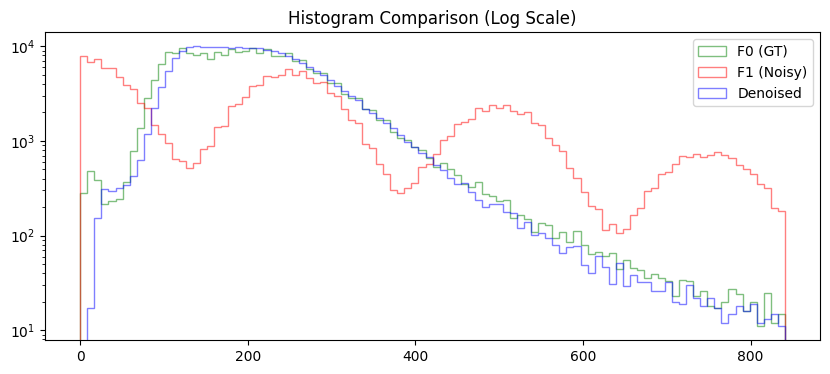

--- Inspecting frame index: 1499 ---
[F0 (GT)] Min: 1.0000, Max: 2393.0000, Mean: 211.3260, Median: 201.0000
[F1 (Noisy)] Min: -213.0000, Max: 5053.0000, Mean: 210.5263, Median: 15.0000
[Denoised] Min: 6.8519, Max: 1491.8564, Mean: 227.6749, Median: 215.4796


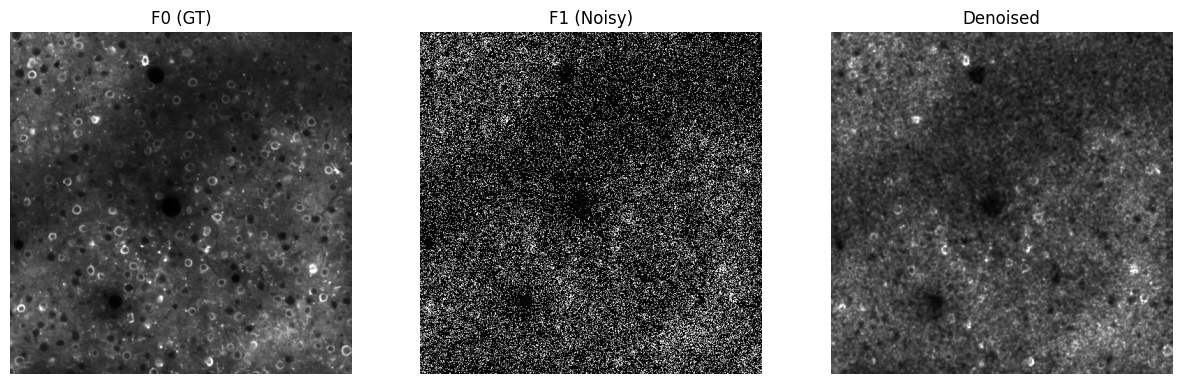

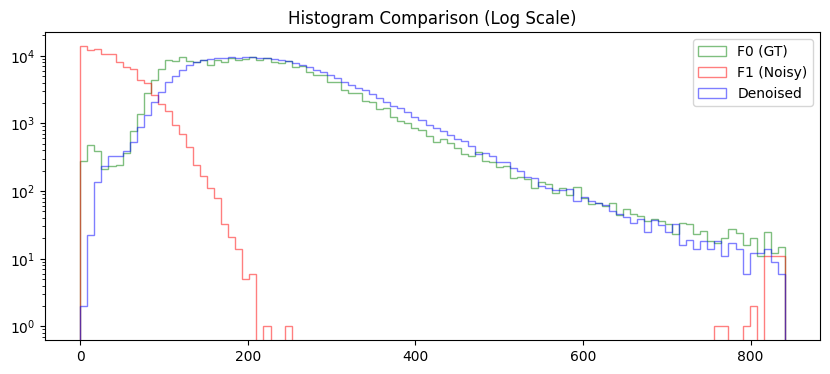

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def inspect_brightness(f0, f1, denoised, img_idx=0):
    """
    輸入三個影像 (假設都是 Numpy Array)
    """

    print(f"--- Inspecting frame index: {img_idx} ---")

    imgs = [f0[img_idx], f1[img_idx], denoised[img_idx]]
    names = ['F0 (GT)', 'F1 (Noisy)', 'Denoised']

    plt.figure(figsize=(15, 5))

    vmin, vmax = np.percentile(f0, (0, 99.9))

    for i, (img, name) in enumerate(zip(imgs, names)):
        # 1. 印出統計數值 (最準確)
        print(f"[{name}] Min: {img.min():.4f}, Max: {img.max():.4f}, Mean: {img.mean():.4f}, Median: {np.median(img):.4f}")

        # 2. 畫圖 (用同樣的 vmin/vmax 比較才公平)
        # 我們統一用 F0 的標準來看
    
        plt.subplot(1, 3, i+1)
        plt.title(name)
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        plt.axis('off')

    plt.show()

    # 3. 畫直方圖 (檢查背景有沒有偏移)
    plt.figure(figsize=(10, 4))
    plt.title("Histogram Comparison (Log Scale)")
    for img, name, color in zip(imgs, names, ['green', 'red', 'blue']):
        # flatten 拉平，bins 設多一點
        plt.hist(img.flatten(), bins=100, range=(vmin, vmax),
                 alpha=0.5, label=name, color=color, log=True, histtype='step')
    plt.legend()
    plt.show()

img_idx = (ground_truth.shape[0]) - 1
inspect_brightness(ground_truth, valid_dataset.images[0], denoised_videos[0], img_idx=img_idx)
inspect_brightness(ground_truth, valid_dataset.images[1], denoised_videos[1], img_idx=img_idx)
inspect_brightness(ground_truth, valid_dataset.images[2], denoised_videos[2], img_idx=img_idx)

In [15]:
from matplotlib import axes
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def interact_viewer(gt, noised, denoised):
    vmin, vmax = np.percentile(gt, (2, 70))
    # vmin, vmax = gt.min(), gt.max()
    print(vmin, vmax)

    def view_frame(t):
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        axs[0, 0].imshow(gt[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[0, 0].set_title(f"Gound Truth (t={t})")
        axs[0, 0].axis('off')

        axs[0, 1].axis('off')

        axs[1, 0].imshow(noised[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[1, 0].set_title(f"Noised (t={t})")
        axs[1, 0].axis('off')

        axs[1, 1].imshow(denoised[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[1, 1].set_title(f"Denoised (t={t})")
        axs[1, 1].axis('off')

        plt.show()

    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(gt)-1,
        step=1,
        description='Time Frame:'
    )

    widgets.interact(view_frame, t=slider)

# interact_viewer(ground_truth, valid_dataset.images[0], denoised_videos[0])
# interact_viewer(valid_dataset.images[0], valid_dataset.images[1])